In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import warnings
import scipy as sp
import time, copy, pickle, matplotlib, os, sys, math, random, itertools
import matplotlib.pyplot as plt
import networkx as nx
import pickle

import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, GCNConv, GATv2Conv
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax, get_laplacian, to_dense_adj

In [3]:
class Eigen1(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
        
    def forward(self, edge_adj):
        # lap_idx, lap_wt = get_laplacian(edge_idx, normalization="sym")
        eigenvals, eigenvecs = torch.linalg.eig(edge_adj)
        top_eig = eigenvecs.squeeze(0)[:, 1:self.k+1]
        top_eig = torch.real(top_eig)
            
        return top_eig

In [6]:
n = 500
d = int(np.ceil(n/(np.log(n)**2)))
p = 0.5
q = 0.1

sizes = [int(n/2), int(n/2)]
probs = [[p,q], [q,p]]
g = nx.stochastic_block_model(sizes, probs)
data = tg.utils.from_networkx(g)
gadj = tg.utils.to_dense_adj(data.edge_index).squeeze(0)

g_test = nx.stochastic_block_model(sizes, probs)
data_test = tg.utils.from_networkx(g_test)
gadj_test = tg.utils.to_dense_adj(data_test.edge_index).squeeze(0)

data.adj_matrix = gadj
data.edge_index_test = data_test.edge_index

EDGE_ATTR_2 = Eigen1(1)(gadj.unsqueeze(0))
EDGE_ATTR_2_test = Eigen1(1)(gadj_test.unsqueeze(0))

In [23]:
idx, _ = torch.where(EDGE_ATTR_2 < 0)
print (idx)
idx, _ = torch.where(EDGE_ATTR_2 > 0)
print (idx)
idx, _ = torch.where(EDGE_ATTR_2 == 0)
print (idx)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

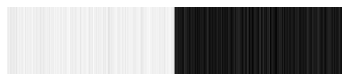

In [36]:
plt.imshow(EDGE_ATTR_2.repeat(1, 100).T.numpy(), cmap="Greys")
plt.title()
plt.axis('off')
plt.show()

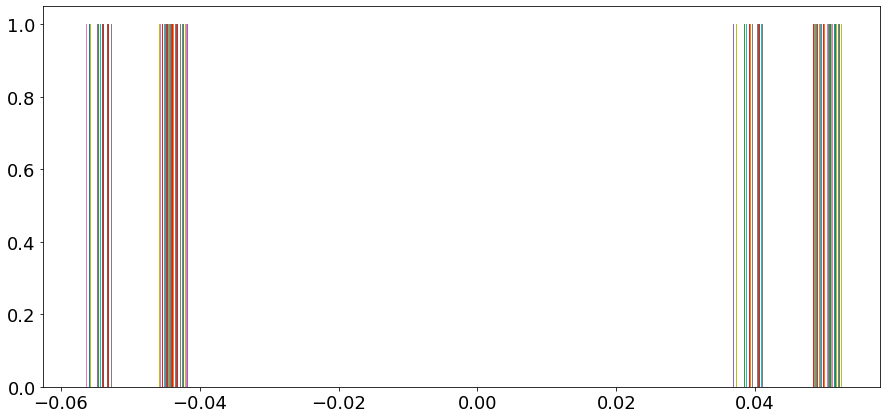

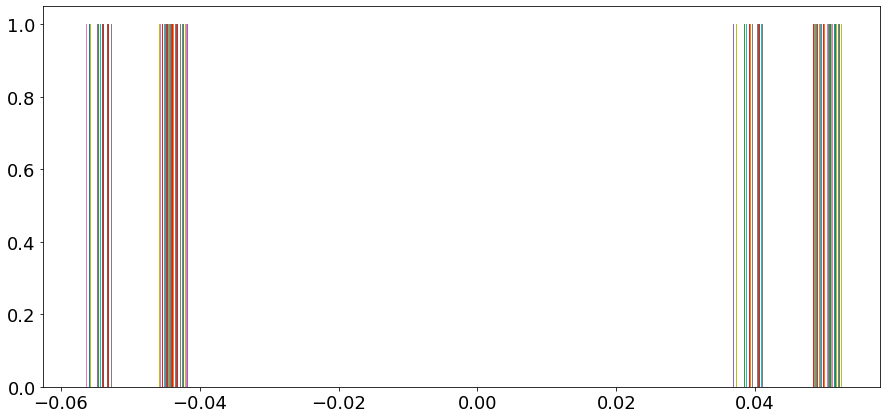

In [37]:
fig = plt.figure(figsize=(15,7))
plt.hist(EDGE_ATTR_2)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.show()

fig = plt.figure(figsize=(15,7))
plt.hist(EDGE_ATTR_2_test)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.show()

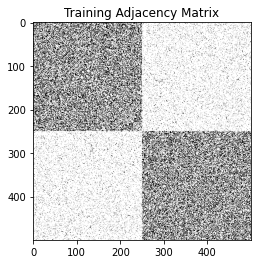

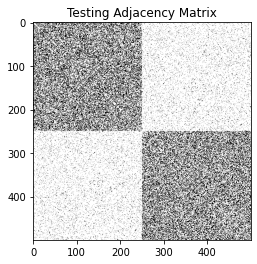

False


In [7]:
plt.imshow(gadj.numpy(), cmap="Greys")
plt.title("Training Adjacency Matrix")
plt.show()

plt.imshow(gadj_test.numpy(), cmap="Greys")
plt.title("Testing Adjacency Matrix")
plt.show()

print (torch.equal(gadj, gadj_test))

In [30]:
which_class = 1
ground_truth = torch.from_numpy(np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2)))))
ground_truth_test = torch.from_numpy(np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2)))))
data.ynew = ground_truth
data.y = ground_truth
data.y_test = ground_truth_test
idx = data.y == which_class

degree = tg.utils.degree(data.edge_index[1], n)

std_ = 0.1
mu_up = 20*std_*np.sqrt(np.log(n**2))/(2*np.sqrt(d))
mu_lb = 0.01*std_/(2*np.sqrt(d))

Nmus = 5
mus = torch.tensor(np.geomspace(mu_lb.item(), mu_up.item(), Nmus, endpoint=True))

In [31]:
mu_ = mus[0]

X = torch.zeros((n, d))
X[:int(n/2)] = -mu_
X[int(n/2):] = mu_
noise = std_ * torch.from_numpy(np.random.randn(n, d))
X = X + noise
X = X.float()

X_test = torch.zeros((n, d))
X_test[:int(n/2)] = -mu_
X_test[int(n/2):] = mu_
noise = std_ * torch.from_numpy(np.random.randn(n, d))
X_test = X_test + noise
X_test = X_test.float()

print (torch.equal(X, X_test))

False
